In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Load image
image = cv2.imread('B2DBy.jpg', cv2.IMREAD_GRAYSCALE)

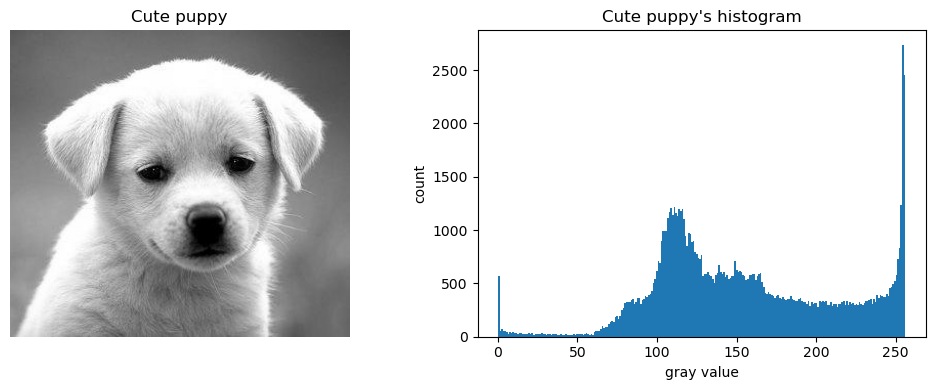

In [41]:
fig, axs = plt.subplots(1, 2, figsize=(10,4))

axs[0].imshow(image, cmap='gray')
axs[0].axis('off')
axs[0].set_title('Cute puppy')

axs[1].hist(image.ravel(), bins=255, range=[0,256])
axs[1].set_xlabel('gray value')
axs[1].set_ylabel('count')
axs[1].set_title('Cute puppy\'s histogram')

plt.tight_layout()
plt.show()

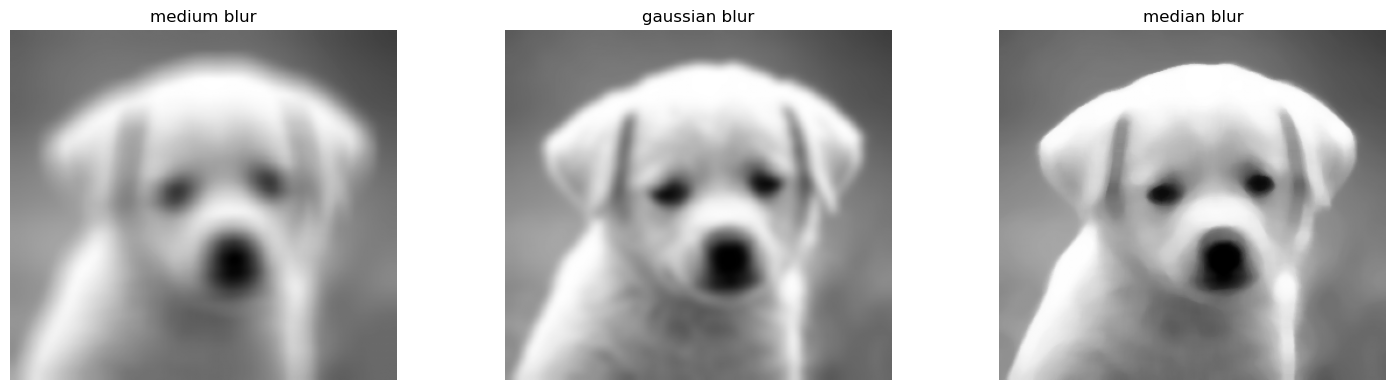

In [60]:
fig, axs = plt.subplots(1, 3, figsize=(15,4))

img_blur_medium = cv2.blur(image, (25,25))
img_blur_gaussian = cv2.GaussianBlur(image, (15,15), 4)
img_blur_median = cv2.medianBlur(image, 15)

axs[0].imshow(img_blur_medium, cmap='gray')
axs[0].set_title('medium blur')
axs[0].axis('off')

axs[1].imshow(img_blur_gaussian, cmap='gray')
axs[1].set_title('gaussian blur')
axs[1].axis('off')

axs[2].imshow(img_blur_median, cmap='gray')
axs[2].set_title('median blur')
axs[2].axis('off')

plt.tight_layout()
plt.show()

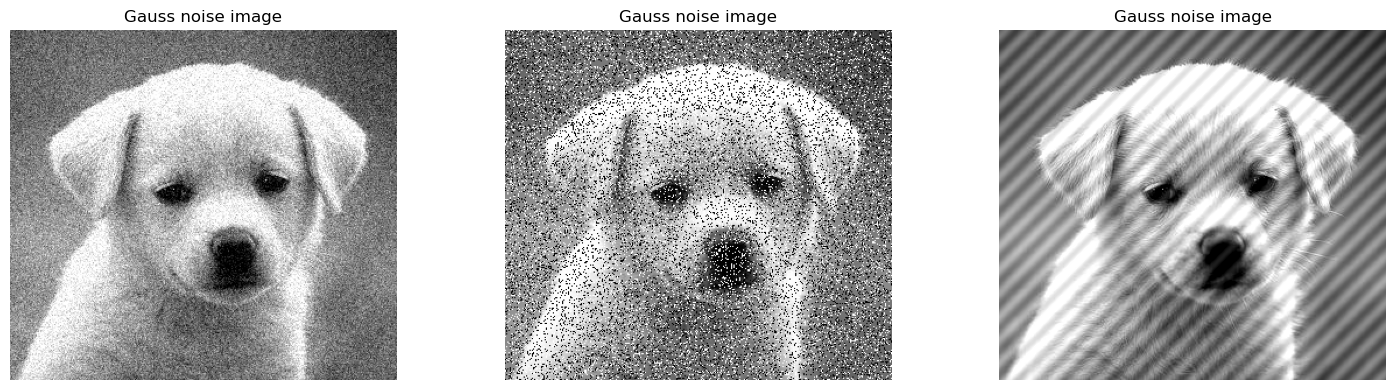

In [25]:
# Apply gauss noise
def gauss_noise(image, mean=0, std=25):
    gauss_noise  = np.random.normal(mean, std, image.shape)
    output = image + gauss_noise
    output = np.clip(output, 0, 255).astype(np.uint8)
    return output

def salt_pepper_noise(image, prob=0.25):
    output = np.copy(image)
    rdn = np.random.rand(*image.shape)
    output[rdn < prob/2] = 0
    output[rdn > 1 - (prob/2)] = 255
    return output

def periodic_noise(image, amplitude, fx=0.05, fy=0.05, phase=0):
    rows, cols = image.shape

    # Cordinate grid
    x = np.arange(cols)
    y = np.arange(rows)
    X, Y = np.meshgrid(x, y)

    noise = amplitude * np.sin(2 * np.pi * (fx * X + fy * Y) + phase)

    output = image + noise 
    output = np.clip(output, 0, 255).astype(np.uint8)

    return output
    
gauss_noise_img = gauss_noise(image)
salt_pepper_image = salt_pepper_noise(image, prob=0.25)
periodic_noise_img = periodic_noise(image,30)

fig, axs = plt.subplots(1,3, figsize=(15,4))

axs[0].imshow(gauss_noise_img, cmap='gray')
axs[0].set_title('Gauss noise image')
axs[0].axis('off')

axs[1].imshow(salt_pepper_image, cmap='gray')
axs[1].set_title('Gauss noise image')
axs[1].axis('off')

axs[2].imshow(periodic_noise_img, cmap='gray')
axs[2].set_title('Gauss noise image')
axs[2].axis('off')

plt.tight_layout()
plt.show()

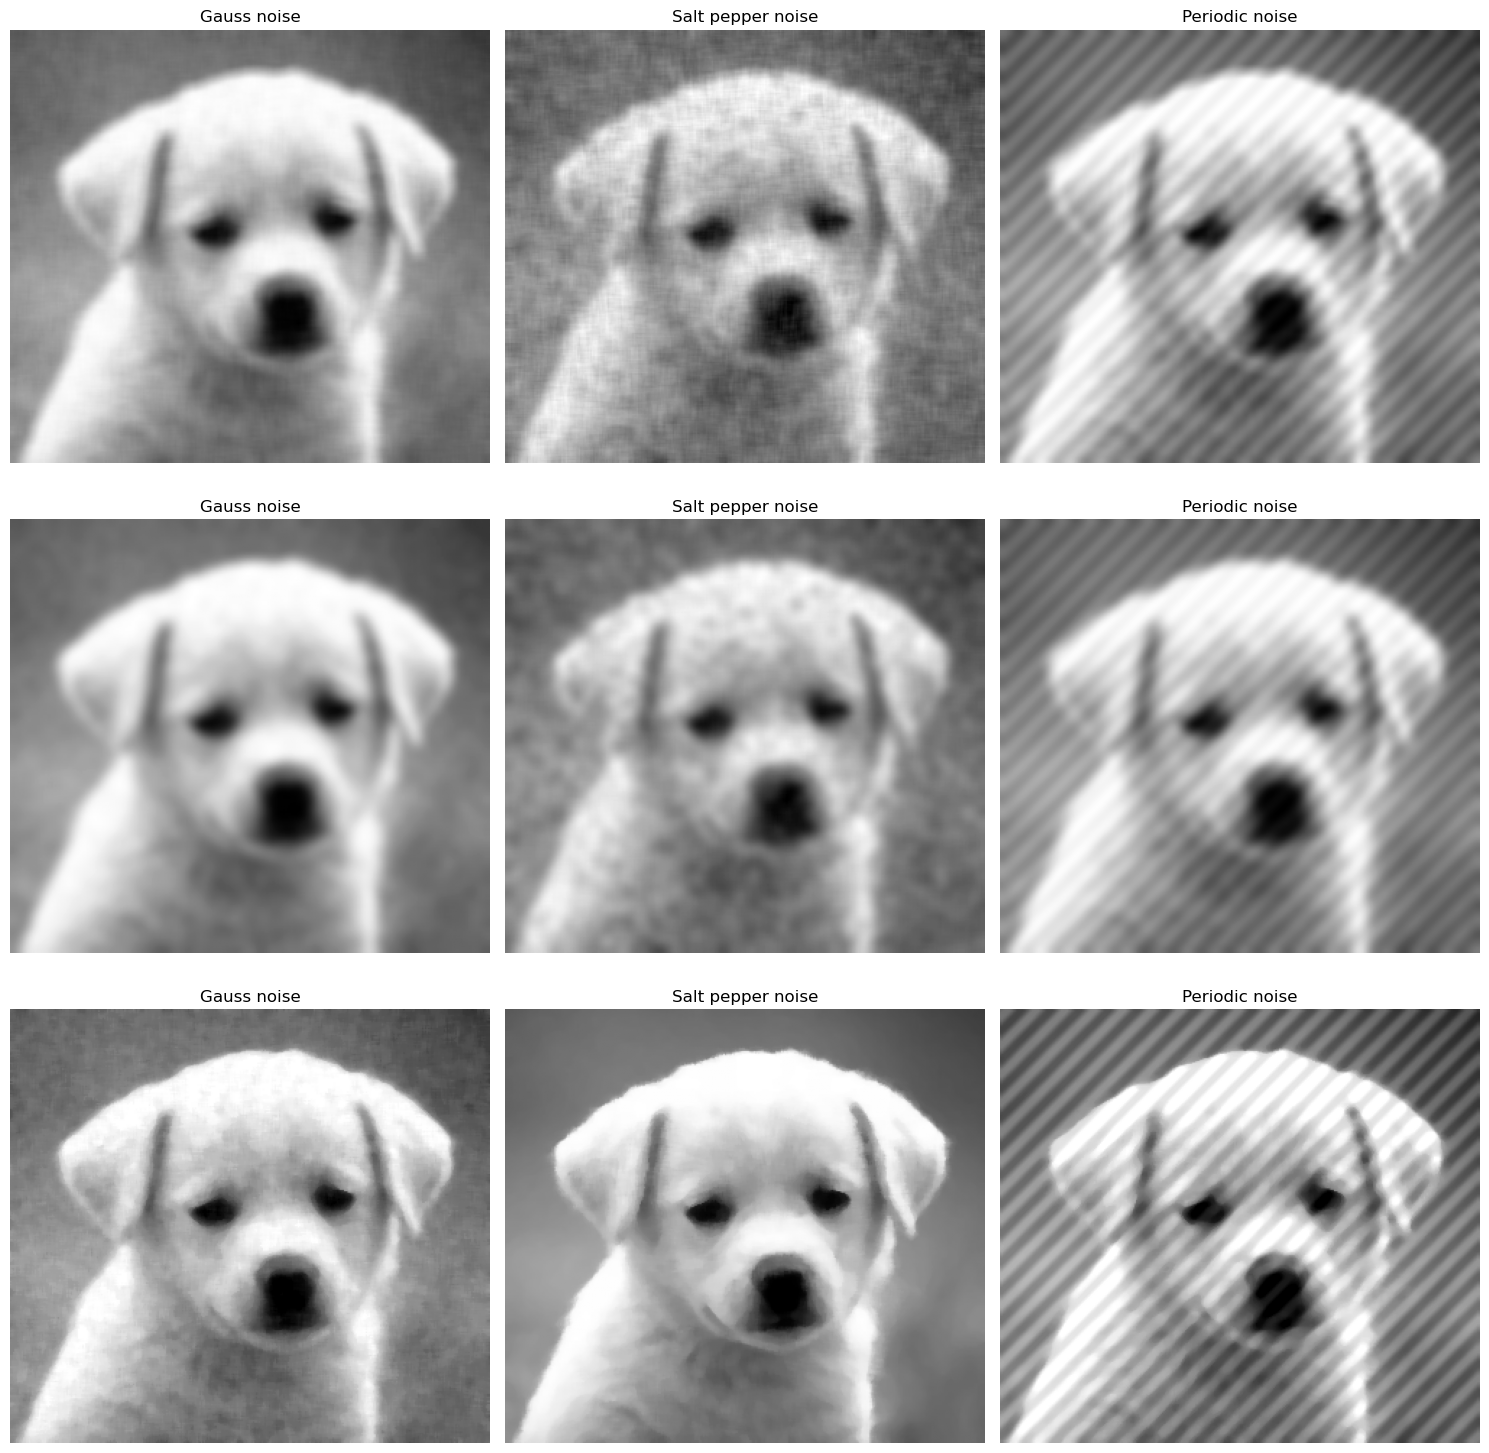

In [32]:
name_noise = ['Gauss noise', 'Salt pepper noise', 'Periodic noise']
name_blur = ['Medium blur', 'Gauss blur', 'Median blur']
noise_image = [gauss_noise_img, salt_pepper_image, periodic_noise_img]
img_process = [[None for _ in range(len(name_blur))] for _ in range(len(name_noise))]

fig, axs = plt.subplots(3, 3, figsize=(15,15))

for i in range(len(name_noise)):
    for j in range(len(name_blur)):
        if i == 0:
            img_process[i][j] = cv2.blur(noise_image[j], (10,10))
        if i == 1:
            img_process[i][j] = cv2.GaussianBlur(noise_image[j], (15,15), 4)
        if i == 2:
            img_process[i][j] = cv2.medianBlur(noise_image[j],7)

# Display the image
for i, blur in enumerate(name_blur):
    for j, noise in enumerate(name_noise):
        axs[i][j].imshow(img_process[i][j], cmap='gray')
        axs[i][j].set_title(noise)
        axs[i][j].axis('off')

plt.tight_layout()
plt.show()

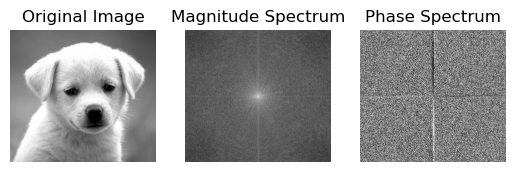

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read image and convert to grayscale
img = cv2.imread('B2DBy.jpg', 0)

# Apply 2D DFT
dft = np.fft.fft2(img)
dft_shifted = np.fft.fftshift(dft)

# Compute magnitude and phase
magnitude = np.abs(dft_shifted)
phase = np.angle(dft_shifted)

# Log scale magnitude for visualization
log_magnitude = np.log(1 + magnitude)

# Display
plt.subplot(1, 3, 1), plt.imshow(img, cmap='gray'), plt.title('Original Image'), plt.axis('off')
plt.subplot(1, 3, 2), plt.imshow(log_magnitude, cmap='gray'), plt.title('Magnitude Spectrum'), plt.axis('off')
plt.subplot(1, 3, 3), plt.imshow(phase, cmap='gray'), plt.title('Phase Spectrum'), plt.axis('off')
plt.show()
